# Linear Models for Classification

This chapter is about performing classification using linear discriminant functions. The discriminant functions are constructed by using a simple linear model $f(x) = w^Tx + w_0$ and setting all values of x to 0 where $f(x) > 0$. The boundary is where $f(x)$ = 0, i.e. where the weight matrix $W^Tx = 0$. For this reason the decision boundary will always be orthogonal to the weight matrix. For $K$ class classification we try to fit such a weight matrix k times. Different than with linear regresiion we now have a one-hot vector $t$ which we regress onto the input matrix.  Since we want to find a matrix that maps the data points from x closest to t we basically are trying to find the inverse from x on t since that would give us W. This can be done using the pseudo-inverse (since x usually isnt square) and is defined as 

$$
    W = (X^TX)^{-1}X^TT
$$

Just as with simple linear regression. The fit of the model can subsequently be determined by the sum of squared, which is equivalent to claculating the trace of the square matrix

$$
   E_D(W) = \frac{1}{2} Tr\{(XW - T)^T(XW -T)\}
$$

In [1118]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

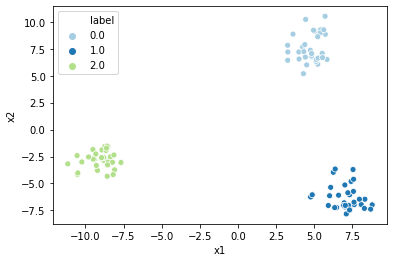

In [1119]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3)

df = pd.DataFrame(np.concatenate([X, y.reshape(-1, 1)], axis=1))
df.columns = ['x1', 'x2', 'label']

sns.scatterplot(x='x1', y='x2', hue='label', data=df, palette="Paired")
plt.show()

In [1120]:
# Augment  the matrix X such that the bias is included in the matrix multiplication
X = np.concatenate([np.ones((100, 1)), X], axis=1)
# Create one-hot matrix of the target label
T = pd.get_dummies(y).values

In [1121]:
# Calculate the Morgan-Penrose pseudo inverse
W = np.linalg.inv(X.T @ X) @ X.T @ T

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


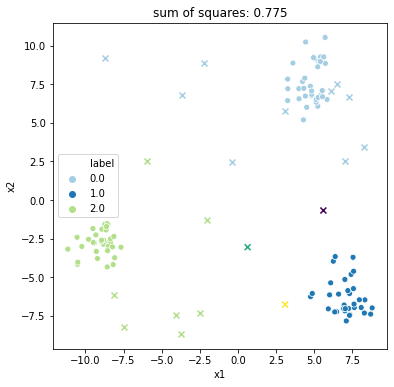

In [1123]:
# To show that it works, sample 20 new test datapoints and assign to the max value after the linear transformation
X_test = np.random.uniform(-10, 10, (2, 20))
X_test = np.concatenate([np.ones((1, 20)), X_test], axis=0)
predictions = np.argmax(W.T @ X_test, axis=0)

# Calculate the sum of squares error
sum_of_squares = (1 / 2) * np.trace(((X @ W) - T).T @ ((X @ W) - T))

plt.figure(figsize=(6, 6))
plt.title(f'sum of squares: {sum_of_squares.round(3)}')
sns.scatterplot(x='x1', y='x2', hue='label', data=df, palette="Paired")
for index, label in enumerate(np.unique(predictions)):
    subset = X_test.T[predictions == label]
    plt.scatter(subset[:,1], subset[:,2], c=sns.color_palette('Paired')[index], marker='x')
    
plt.show()

In [1124]:
probabilities = (W.T @ X_test).T

In [1125]:
probabilities.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [1126]:
probabilities[probabilities > 1.0]

array([1.00064522])

In [1127]:
probabilities[probabilities < 0.0]

array([-0.17085464, -0.18284835, -0.07059678, -0.2220976 , -0.21345317,
       -0.72183787, -0.36254983, -0.33424138, -0.10135529, -0.14485539,
       -0.39778205, -0.25209335, -0.08486469, -0.08421904, -0.33267705])

As you can see the probabilities do sum to 1, however not all scores are $\in [0,1]$ so this type of classification will not result in a valid probability distribution

## Fisher linear discriminant

To account for these problems you can for example use a fisher linear discriminant. What you basically do with classification is performing feature reduction into a single number. This can ofcourse not give good results. Using the Fisher discriminant you try to find a mapping that maximizes the inter-class variance and minimize the intra-class variacne (i.e. seperate clusters as good as possible but keep similar items close). The Fisher discriminant is determined as the ratio between the inter class variance divided by the intra variance of each class, i.e.;

$$
    J(W) = \frac{(m_2 - m_1)^2}{s_1^2 + s_2^2}
$$

or using matrix notation

$$
    J(W) = \frac{w^TS_Bw}{w^TS_Ww}
$$

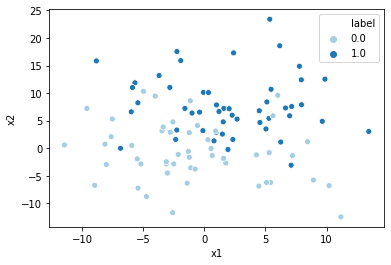

In [1128]:
X, y = make_blobs(n_samples=100, n_features=2, centers=2, cluster_std=5)

df = pd.DataFrame(np.concatenate([X, y.reshape(-1, 1)], axis=1))
df.columns = ['x1', 'x2', 'label']

sns.scatterplot(x='x1', y='x2', hue='label', data=df, palette="Paired")
plt.show()

In [1129]:
c1 = X[y == 0]
c2 = X[y == 1]

m1 = c1.mean(axis=0).reshape(-1, 1)
m2 = c2.mean(axis=0).reshape(-1, 1)

X = X.T

In [1130]:
s_b = (m2 - m1) @ (m2 - m1).T # Inter class variance
s_w = (c1.T - m1) @ (c1.T - m1).T + (c2.T - m1) @ (c2.T - m1).T # Intra class variance

In [1131]:
w = np.linalg.inv(s_w) @ (m2 - m1)

In [1132]:
preds_c1 = w.T @ c1.T # We have now performed dimensionality reduction by mapping all the input vectors to a number
preds_c2 = w.T @ c2.T # We have now performed dimensionality reduction by mapping all the input vectors to a number

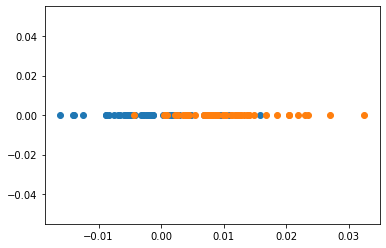

In [1133]:
plt.scatter(preds_c1, np.zeros(preds_c1.size)) # Plotting the Fisher discriminant
plt.scatter(preds_c2, np.zeros(preds_c2.size))

Note that these values are not yet probabilities, we can try to estimate the class conditional densities ($p(y|c_k$) by fitting both datasets using gaussians. We can be quite certain that using a gaussion prior makes sense considering the classficiation is based on a set of random variables

In [1134]:
from scipy.stats import norm

In [1135]:
def calculate_gaussian_MLE(data):
    mean = np.mean(data)
    variance = np.std(data)
    
    return mean, variance

In [1136]:
m1, std1 = calculate_gaussian_MLE(preds_c1[0])
m2, std2 = calculate_gaussian_MLE(preds_c2)

In [1137]:
range_ = np.linspace(np.vstack([preds_c1, preds_c2]).min(), np.vstack([preds_c1, preds_c2]).max(), 100)

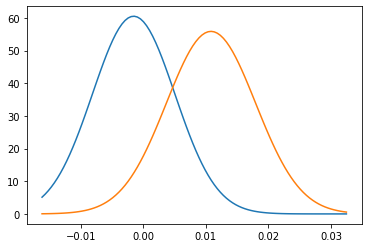

In [1138]:
norm1 = norm(m1, std1)
norm2 = norm(m2, std2)
plt.plot(range_, norm1.pdf(range_))
plt.plot(range_, norm2.pdf(range_))

These give the likelihoods of the data ($P(x | C_k)$. Now we. can calculate the Posterior ($P(C_k | x)$ by using bayes rule. We ommit the demoninator

$$
    p(C_k | x) = \frac{p(x | C_k)p(C_k)}{p(x)}
$$

In [1139]:
pred_all = w.T @ X

In [1140]:
posteriors1 = norm1.pdf(pred_all) * (c1.shape[0] / X.shape[1]) # Likelihood * prior
posteriors2 = norm2.pdf(pred_all) * (c2.shape[0] / X.shape[1])

In [1141]:
probs = np.concatenate([posteriors1.T, posteriors2.T], axis=1)
probs = probs / probs.sum(axis=1).reshape(-1, 1)

In [1142]:
probs[:5] # Now we have proper probabilities and we can select the max

array([[0.36181278, 0.63818722],
       [0.18652818, 0.81347182],
       [0.58155041, 0.41844959],
       [0.72499162, 0.27500838],
       [0.9035844 , 0.0964156 ]])

In [1143]:
from sklearn.metrics import classification_report

In [1144]:
print(classification_report(y_pred=np.argmax(probs, axis=1), y_true=y))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83        50
           1       0.85      0.78      0.81        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100



## Perceptron

Is a different method for performing linear classification. Other than performing least squeres by regressing the target on the input or modelling the inter and intra variance of the data the idea is to start with a random vector $w$ and iteratively update the model on whether its prediction was wrong. The function is defined as 

$$
    y(x) = f(w^T\phi(x))
$$

Where $y(x)$ is a step function that give 1 iff $y(x) > 0$ and -1 otherwise. If you use this target labelling you would like to have $w^T\phi(x_n)t_n > 0$ for each data point. For that reason you can calculate the error (or perceptron criterion) as being the negative sum of all the misclassified examples

$$
    E_p(w) = - \sum_{n \in M} w^T\phi_nt_n
$$

Note that the magnitude of the error linearly add to the entrie error. This makes the model very sensitve to outliers. The model is trained by going through the training data and update the weight vector each time the classification is wrong

$$
    w^{\tau + 1} = w^{\tau} + \eta\phi_nt_n
$$

For now we just focus on linearieties so we assume that $\phi(x) = x$ although we do add a constant 1 to the front to account for the bias

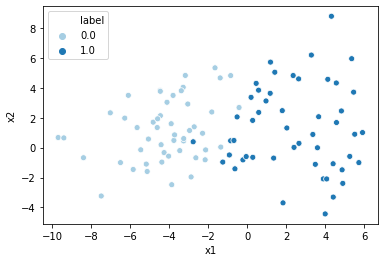

In [1251]:
X, y = make_blobs(n_samples=100, n_features=2, centers=2, cluster_std=2.5)

df = pd.DataFrame(np.concatenate([X, y.reshape(-1, 1)], axis=1))
df.columns = ['x1', 'x2', 'label']

sns.scatterplot(x='x1', y='x2', hue='label', data=df, palette="Paired")
plt.show()

X = np.concatenate([np.ones(100).reshape(-1, 1), X], axis=1).T # Add bias term and convert to column vectors


In [1252]:
y[np.where(y == 0)] = -1 # Encode the targets as -1 and 1, this is needed for the perceptron criterion§

w = np.random.normal(0, 1, (3, 1)) # Init the 3x1 weight matrix (2 features and 2 classes)

lr = 1

num_wrong = []

for i in range(100): # Number of epochs 
    n_wrong = 0
    for i in range(X.shape[1]): # Loop over all the training instances
        x = X[:, i]

        prediction = ((w.T @ x) >= 0).astype(int)[0]

        if prediction == 0: # Transform to -1 and 1
            prediction = -1

        if prediction != y[i]:
            n_wrong += 1
            w = w + (lr * x * y[i]).reshape(-1, 1) # Derivative of w^Txy = xy
            
    num_wrong.append(n_wrong)

Text(0, 0.5, 'Number wrong')

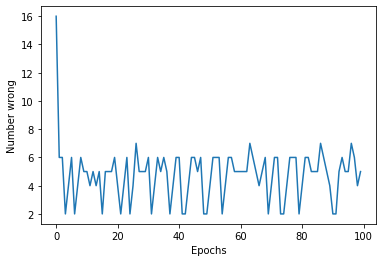

In [1254]:
plt.plot(num_wrong)
plt.xlabel('Epochs')
plt.ylabel('Number wrong')

In [1255]:
prds = ((w.T @ X) > 0)[0].astype(int)

prds[np.argwhere(prds == 0)] = -1

print(classification_report(y_pred=prds, y_true=y))

              precision    recall  f1-score   support

          -1       0.98      0.94      0.96        50
           1       0.94      0.98      0.96        50

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



A few things we can take from this graph. In the beginning we see that the number of errors quickly decreases considering the model will always make some mistakes because of class overlap. 

## Probabilistic Generative Models

Generative is different from a simple discrminant function because you actually model the distributions from the input instead of only doing a classification

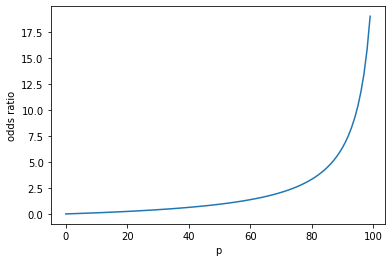

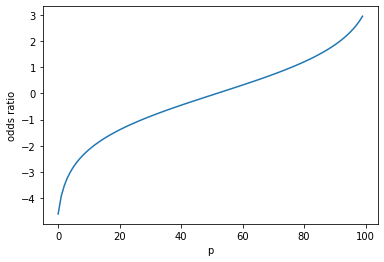

In [1256]:
p = np.linspace(0.01, 0.95, 100)

plt.figure()
plt.plot(p / (1 - p))
plt.xlabel('p')
plt.ylabel('odds ratio')

plt.figure()
plt.plot(np.log(p / (1 - p)))
plt.xlabel('p')
plt.ylabel('odds ratio')

plt.show()

The top bar shows the odds ratio for a given p, i.e. $P(c_1|x)$. The bottom one is the log of the odds ratio. We would like to give a linear transformation ($\alpha = b_0 + b1x$ of the input give the log ratio of the probability of class 1 of occuring ($P(C_1|x) = p$), i.e.

$$
    log(\frac{p}{1 - p}) = a \\
    \frac{p}{1 - p} = e^a \\
    \frac{1}{p} - \frac{p}{p} = e^a \\
    \frac{1}{p} - 1 = e^a \\
    \frac{1}{p} = 1 + e^a \\
    \frac{1}{p} = \frac{1}{e^a} + \frac{e^a}{e^a}\\
    \frac{1}{p} = \frac{1 + e^a}{e^a} \\
    p = \frac{e^a}{1 + e^a} \\
    p = \frac{1}{1 + e^{-a}} \\
    P(C_1|x) = \frac{1}{1 + e^{b_0 + b_1 x}}
$$

So what we can do is model the conditional probabilities of a two-class classification problem by computing the logistic sigmoid of the input. As an example, lets assume 2 classes which have a Gaussian class conditional

In [1257]:
norm1 = norm(2.5, 0.5)
norm2 = norm(1.5, 0.5)

In [1258]:
c1.shape

(100, 2)

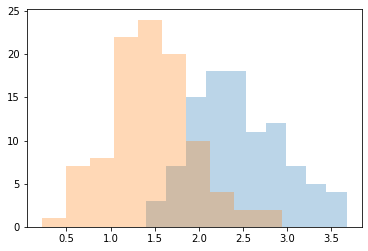

In [1259]:
c1 = norm1.rvs(100).reshape(1, -1)
c2 = norm2.rvs(100).reshape(1, -1)

plt.hist(c1.T, alpha=0.30)
plt.hist(c2.T, alpha=0.30)
plt.show()

In [1260]:
mean1 = c1.mean(axis=1).reshape(-1, 1)
mean2 = c2.mean(axis=1).reshape(-1, 1)
cov = np.array([0.50]).reshape(-1, 1)

In [1261]:
# Calculate the parameters for 2 Gaussians having the same covariance matrix
w = np.linalg.inv(cov) @ (mean1 - mean2)
w0 = ((-1/2) * mean1.T @ np.linalg.inv(cov) @ mean1) + ((1/2) * mean2.T @ np.linalg.inv(cov) @ mean2) + np.log(0.50/0.50)

In [1262]:
x_range = np.linspace(0, 4, 100)
a = (w.T @ x_range.reshape(1, -1) + w0).reshape(-1, 1)

In [1263]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

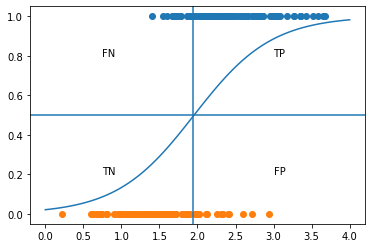

In [1264]:
plt.plot(np.linspace(0, 4, 100), sigmoid(a))
plt.scatter(c1, np.ones(c1.size)) 
plt.scatter(c2, np.zeros(c2.size))
plt.axvline(np.linspace(0, 4, 100)[np.argmax(sigmoid(a) * (1 - sigmoid(a)))])
plt.text(0.75, 0.80, 'FN')
plt.text(0.75, 0.20, 'TN')
plt.text(3, 0.20, 'FP')
plt.text(3, 0.80, 'TP')
plt.axhline(0.50)

## Probabilistic Discriminative Models

The method above is called generative because we are modelling the distributions class conditional probabilities and the prior probabilities. 

$$
    \frac{P(x |C_1)P(C_1)}{P(x)}
$$

Here we could generate new data given the distributions that we modelled. However this can be quite computationally expensive and a better way would be to maximize the likelihood of the data via the posterior probability. i.e. we are trying to find a $P(C_1|x)$ that maximizes the data that we have. The main advantage is that we only need to store M parameters to fit the model, one for each of the basis functions

$$
    p(c_1|\phi) = \sigma(w^T\phi)
$$

Since we will be using MLE we need the derivative of $\sigma = \frac{1}{1 + e^{-a}}$ which van be found using the quotient rule of calculus

$$
\frac{1}{1 + e^{-a}} \\
\frac{e^{-a}}{(1 + e^{-a})^2} \\
\frac{1 - 1 + e^{-a}}{(1 + e^{-a})^2} \\
\frac{(1 + e^{-a})}{(1 + e^{-a})^2} \frac{1}{(1 + e^{-a})^2} \\
\frac{1}{(1 + e^{-a})} \frac{1}{(1 + e^{-a})^2} \\
\frac{1}{(1 + e^{-a})}(1 - \frac{1}{(1 + e^{-a})}) \\
\frac{d\sigma}{a} = \sigma(a)(1 - \sigma(a))
$$

In our case we are going to peform binary classification so the maximum likelihood of a binary classification given a weight vector $w$ can be given a product of bernoulli trials

$$
p(t|w) = \prod_{n=1}^Ny_{n}^{t_n} ( 1 - y_n)^{1 - t_n}
$$

where $t \in \{0,1\}$ and the target $y = P(c_1|\phi_n)$ is the sigmoid of the linear transformation of the weight vector with the basis functions, i.e. $\sigma(w^T\phi)$. Taking the log-likelihood gives us 

$$
   E(W) = t_n \; ln(y) + (1 - t_n) \; ln(1 - y)
$$

We want to find the derivative wrt $w$ so we need to apply the chain rule, $\frac{dE}{dy}\frac{dy}{da}\frac{da}{w}$ thus we get

$$
\frac{dE}{dy}\frac{dy}{da}\frac{da}{w} = \frac{y - t}{y (1 - y)} y (1- y) \phi \\
 = (y - t)\phi \\
$$

This is the same optimization as you would have for linear regression. However, the solution has no closed form solution considering there is a non-linear sigmoidal function. The function IS convex however, meaning that there is 1 optimal solution. We are going to solve this by applying basis functions to a problem that is not linearly seperable in the input space

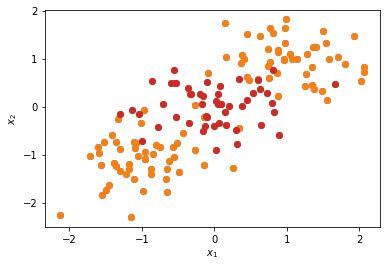

In [1457]:
variance = 0.5

c1 = np.vstack([np.random.normal([-1, -1], variance, (50, 2)), np.random.normal([1, 1], variance, (50, 2))])
c2 = np.random.normal([0, 0], variance, (50, 2))

data = np.vstack([c1,c2])
labels = np.concatenate([np.zeros(100).reshape(-1, 1), np.ones(50).reshape(-1, 1)], axis=0).flatten()

for i in range(2):
    subset = data[labels == i]
    
    plt.scatter(subset[:,0], subset[:,1])
    plt.scatter(subset[:,0], subset[:,1])
    
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

In [1458]:
# For now we specify the basis functions
phi0 = lambda x: 1
phi1 = lambda x: np.exp(-np.linalg.norm(x - np.array([-1, -1])) / 2)
phi2 = lambda x: np.exp(-np.linalg.norm(x - np.array([0, 0])) / 2)

In [1459]:
p0 = list(map(phi0, data))
p1 = list(map(phi1, data))
p2 = list(map(phi2, data))

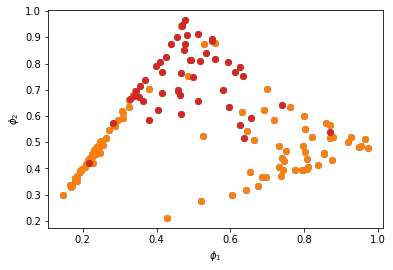

In [1460]:
# Transform the data using the 2 gaussian basis functions
transformed = np.vstack([p0, p1, p2]).T # N X M 

for i in range(2):
    subset = transformed[labels == i]
    
    plt.scatter(subset[:,1], subset[:,2])
    plt.scatter(subset[:,1], subset[:,2])

plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$')
plt.show()

transformed = transformed.T

Now the problem is linearly seperable and thus we can now apply standard methods to find a decision boundary that splits the classes. Because of the sigmoid function the optimal solution is no longer closed-form and we need an alternative approach for finding the optimal w. This can be done using the Newton-Raphson update

$$
    w^{new} = w^{old} - H^{-1}\nabla E(W)
$$

Where H is the inverse of the double derivative of E. The second derivative of E found again by the chain rule

$$
    \frac{dE}{y}\frac{dy}{a}\frac{da}{w} = y(1 - y) \phi \phi^T
$$

set $R = y(1 - y)$

$$
    H = \phi^T R \phi
$$

Note that y depends on w so you cannot optimize the error without the weight vector itself. However because the probability is always between 0 and 1 the hessian matrix will always be higher than 0. i.e. it is always possible to find the optimal solution considering you can always update the weight matrix. Adding this to the Newton-Raphson and doing some shuffling with terms we get

$$
    w_n = (\phi^T R \phi)^{-1} \phi^T R (\phi w_o - R^{-1}(y - t))
$$

where $z = (\phi w_o - R^{-1}(y - t)$

This has to be iteratively applied because the error term changes with w when we change w. 

In [1467]:
from sklearn.metrics import roc_curve

In [1461]:
labels = labels.reshape(-1, 1)
sigmoid = lambda x: 1 / (1 + np.exp(-x))

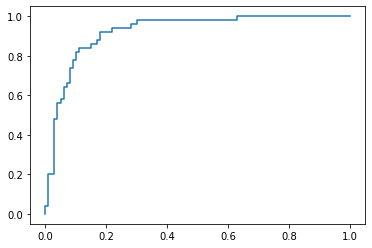

In [1469]:
w = np.zeros((3, 1)) # Initialize to zeros (all 0.50 pro)

for i in range(10):
    design_matrix = transformed.T
    y = sigmoid(w.T @ transformed).T
    R = np.diag((y * (1 - y)).flatten()) # Note that R (the variances) will go to zero so you have to stop some time
    z = (design_matrix @ w) - (np.linalg.inv(R) @ (y - labels))
    w = np.linalg.inv(design_matrix.T @ R @ design_matrix) @ design_matrix.T @ R @ z

probabilities = sigmoid(w.T @ transformed)
fpr, tpr, thresholds = roc_curve(y_score=probabilities.flatten(), y_true=labels)
plt.figure()
plt.plot(fpr, tpr)
plt.show()